In [1]:
import math
import random
import cupy as cp
from cupy.random import multivariate_normal as mvn

import torch
import torch.nn
import torch.nn.functional
from torch.optim import Adam

import matplotlib.pyplot as plt

from tqdm.auto import tqdm


In [2]:
dev=torch.device("cuda:0")
print(cp.cuda.Device(0).compute_capability)

random_seed=23301522
random.seed(random_seed)
cp.random.seed(random_seed)
torch.manual_seed(random_seed)


61


In [3]:
def draw_data(p,q,title=""):
  sek=(
    "xkcd:hospital green",
    "xkcd:blood red",
  )
  
  fig,ax=plt.subplots(figsize=(10,2))

  [ax.scatter(
    data[1][:,0],data[1][:,1],
    label=f"{data[0]}",color=data[2],alpha=.2) for data in zip((0,1),(p,q),sek)]
  ax.set_title(title)
  ax.legend(loc="lower left")

  return 


/home/yuninze/conda/envs/origin/lib/python3.10/site-packages/cupy/random/_distributions.py:476: FutureWarning: cupy.random.multivariate_normal is experimental. The interface can change in the future.
  _util.experimental('cupy.random.multivariate_normal')
/home/yuninze/conda/envs/origin/lib/python3.10/site-packages/cupy/random/_generator.py:344: FutureWarning: cupy.random.RandomState.multivariate_normal is experimental. The interface can change in the future.
  _util.experimental('cupy.random.RandomState.multivariate_normal')


p.shape=(1024, 2) q.shape=(1024, 2) data.shape=torch.Size([2048, 2])


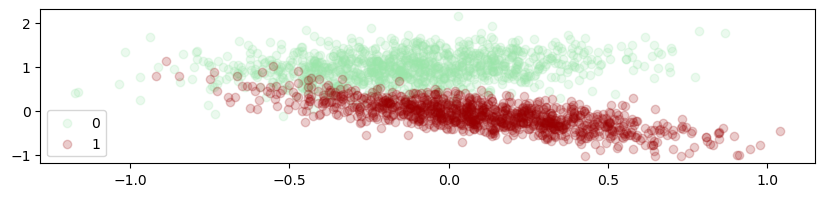

In [4]:
dtl=cp.float64

dim=2
count=1024**1

p_mean=cp.array([-.1,1])
p_cov=cp.array([
  [.1,.02],[.02,.1]
])

q_mean=cp.array([.1,-.1])
q_cov=cp.array([
  [.1,-.07],[-.07,.1]
])

p=mvn(p_mean,p_cov,count,dtype=dtl)
q=mvn(q_mean,q_cov,count,dtype=dtl)

data=torch.cat([
  torch.as_tensor(p).to(dev),
  torch.as_tensor(q).to(dev)
])
data_label=torch.as_tensor(
  cp.concatenate(
    [cp.zeros(len(q)),cp.ones(len(p))],
  )
)

print(f"{p.shape=} {q.shape=} {data.shape=}")

draw_data(p.get(),q.get())


In [83]:
class DM(torch.nn.Module):
  def __init__(
    self,
    network,
    step_count=10**3,
    beta=(10**-4,.02),
    device=None
  ):
    super().__init__()
    
    self.device=device
    self.network=network.to(self.device)
    self.step_count=step_count
    self.beta=torch.linspace(beta[0],beta[1],step_count).to(self.device)
    self.alpha=1-self.beta
    self.alpha_bar=torch.tensor(
      [torch.prod(self.alpha[:q+1]) for q in range(len(self.alpha))]
    ).to(self.device)

  def forward(self,
    x0,
    t,
    eta=None
  ):
    n,d=x0.shape
    _alpha_bar=self.alpha_bar[t]

    if eta is None:eta=torch.randn(n,d).to(self.device)

    return _alpha_bar.sqrt().reshape(n,1)*x0 \
      + (1-_alpha_bar).sqrt().reshape(n,1)*eta
  
  def backward(self,x,t):
    return self.network(x,t)
  
  def backward_masked(self,x,t,c,c_mask):
    return self.network(x,t,c,c_mask)


In [84]:
class EmbedBlock(torch.nn.Module):
  '''An embedding layer'''
  def __init__(self,input_dim,emb_dim):
    super().__init__()

    self.input_dim=input_dim
    layer=[
      torch.nn.Linear(input_dim,emb_dim),
      torch.nn.GELU(),
      torch.nn.Linear(emb_dim,emb_dim),
      torch.nn.Unflatten(1,(emb_dim,))
    ]
    self.model=torch.nn.Sequential(*layer)

  def forward(self,x):
    return self.model(x.view(-1,self.input_dim))


In [85]:
class SinusoidalEmbedBlock(torch.nn.Module):
  '''A layer regards theta'''
  def __init__(self,dim):
    super().__init__()
    self.dim=dim
  
  def forward(self,time):
    device=time.device
    half_dim=self.dim//2
    embedding=math.log(10**4)/(half_dim-1)
    embedding=torch.exp(torch.arange(half_dim,device=device)*-embedding)
    embedding=time[:,None]*embedding[None,:]
    embedding=torch.cat(embedding.sin(),embedding.cos(),dim=-1)
    return embedding


In [86]:
class EpsilonDiffuse(torch.nn.Module):
  def __init__(
    self,
    input_dim,
    output_dim,
    T,
    ns_layer=[10,5,3],
    t_embed_dim=8,
    c_embed_dim=3
  ):
    super().__init__()

    self.T=T
    self.fc1=torch.nn.Linear(input_dim,ns_layer[0],bias=True)
    self.fc2=torch.nn.Linear(ns_layer[0],ns_layer[1],bias=True)
    self.fc3=torch.nn.Linear(ns_layer[1],ns_layer[2],bias=True)
    self.fc4=torch.nn.Linear(ns_layer[2],output_dim)

    self.sinusoidaltime=SinusoidalEmbedBlock(t_embed_dim)
    self.t_emb1=EmbedBlock(t_embed_dim,ns_layer[0])
    self.t_emb2=EmbedBlock(t_embed_dim,ns_layer[1])
    self.c_embed1=EmbedBlock(c_embed_dim,ns_layer[0])
    self.c_embed2=EmbedBlock(c_embed_dim,ns_layer[1])
  
  def forward(
    self,
    x,
    t,
    c,
    c_mask
  ):
    t=t.float()/self.T
    t=self.sinusoidaltime(t)
    t_emb1=self.t_emb1(t)
    t_emb2=self.t_emb2(t)

    c=c*c_mask
    c_emb1=self.c_embed1(c)
    c_emb2=self.c_embed2(c)

    out=torch.relu(self.fc1(x))
    out=torch.relu(self.fc2(c_emb1*out + t_emb1))
    out=torch.relu(self.fc3(c_emb2*out + t_emb2))
    out=self.fc4(out)
    
    return out


In [87]:
def get_class_mask(
  c,
  class_count,
  drop_probability,
  device
):
  c_code=torch.nn.functional.one_hot(
    c.to(torch.int64),
    num_classes=class_count
  ).to(device)

  c_mask=torch.bernoulli(
    torch.ones_like(c_code).float() - drop_probability
  ).to(device)

  return c_code,c_mask

In [88]:
def loop(
  dm:DM,
  x0,
  label,
  epoch_count,
  optimizer,
  class_count,
  device,
  drop_probability,
  store_path="./dm/",
):
  mse=torch.nn.MSELoss()
  lowest_loss=float("inf")
  step_count=dm.step_count

  for epoch in tqdm(range(epoch_count),desc="Progress"):
    epoch_loss=.0
    x0_n=len(x0)
    c_code,c_mask=get_class_mask(
      c=label,
      drop_probability=drop_probability,
      class_count=class_count,
      device=device
    )

    eta=torch.randn_like(x0).to(device)
    t=torch.randint(0,step_count,(x0_n,)).to(device)
    
    t_=dm(x0,t,eta)

    print(f"{eta.shape=}, {t.shape=}, {t_.shape=}")

    eta_theta=dm.backward_masked(
      t_,
      t.reshape(x0_n,-1),
      c_code,
      c_mask
    )

    loss=mse(eta_theta,eta)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    epoch_loss+=loss.item()*x0_n/len(x0)

    if lowest_loss>epoch_loss:
      lowest_loss=epoch_loss
      torch.save(dm.state_dict(),store_path)

    try:
      show_image(
        generate_image(dm,device=device,),
        f"Image at Epoch {epoch+1}"
      )
    except:
      pass
    finally:
      print("Currently At:",f"{epoch+1} {epoch_loss:.3f} for {lowest_loss}")



In [89]:
T_col=8
T_row=10
T=T_col*T_row

Model=DM(
  EpsilonDiffuse(dim,dim,T),
  device=dev
)


In [90]:
epoch_count=10**3
class_count=2
lr=10e-3

loop(
  Model,
  x0=data,
  label=data_label,
  class_count=class_count,
  drop_probability=.05,
  epoch_count=epoch_count,
  optimizer=Adam(Model.parameters(),lr),
  device=dev,
)


Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

eta.shape=torch.Size([2048, 2]), t.shape=torch.Size([2048]), t_.shape=torch.Size([2048, 2])


TypeError: cat() received an invalid combination of arguments - got (Tensor, Tensor, dim=int), but expected one of:
 * (tuple of Tensors tensors, int dim = 0, *, Tensor out = None)
 * (tuple of Tensors tensors, name dim, *, Tensor out = None)
